# Training

In [1]:
import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import numpy as np
import pandas as pd
import timm
import torchvision.transforms as T
from wildlife_datasets.datasets import AnimalCLEF2025
from wildlife_tools.features import DeepFeatures
from wildlife_tools.similarity import CosineSimilarity
def create_sample_submission(dataset_query, predictions, file_name='sample_submission.csv'):
    df = pd.DataFrame({
        'image_id': dataset_query.metadata['image_id'],
        'identity': predictions
    })
    df.to_csv(file_name, index=False)
root = '.'

/home/congzheng/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from typing import List, Union

def BAKS(
    y_true: torch.Tensor,
    y_pred: torch.Tensor,
    identity_test_only: Union[List, torch.Tensor]
) -> float:
    """Balanced Accuracy on Known Samples using PyTorch."""
    if isinstance(identity_test_only, list):
        identity_test_only = torch.tensor(identity_test_only, dtype=y_true.dtype, device=y_true.device)

    # Mask for known identities
    mask = ~torch.isin(y_true, identity_test_only)
    y_true_known = y_true[mask]
    y_pred_known = y_pred[mask]

    if y_true_known.numel() == 0:
        return float('nan')

    unique_labels = torch.unique(y_true_known)
    acc = 0.0
    for label in unique_labels:
        idx = y_true_known == label
        acc_class = torch.mean((y_pred_known[idx] == label).float())
        acc += acc_class.item()
    return acc / len(unique_labels)

def BAUS(
    y_true: torch.Tensor,
    y_pred: torch.Tensor,
    identity_test_only: Union[List, torch.Tensor],
    new_class: Union[int, str]
) -> float:
    """Balanced Accuracy on Unknown Samples using PyTorch."""
    if isinstance(identity_test_only, list):
        identity_test_only = torch.tensor(identity_test_only, dtype=y_true.dtype, device=y_true.device)

    # Mask for unknown identities
    mask = torch.isin(y_true, identity_test_only)
    y_true_unknown = y_true[mask]
    y_pred_unknown = y_pred[mask]

    if y_true_unknown.numel() == 0:
        return float('nan')

    unique_labels = torch.unique(y_true_unknown)
    acc = 0.0
    for label in unique_labels:
        idx = y_true_unknown == label
        acc_class = torch.mean((y_pred_unknown[idx] == new_class).float())
        acc += acc_class.item()
    return acc / len(unique_labels)


## Params

In [3]:
import logging
from datetime import datetime

seed = 42
# 提交kaggle前data_split设为1！！
data_split = 1
batch_size = 128
num_epochs = 10
lr = 1e-4
pretrain_model = 'swin_tiny_patch4_window7_224'
output_model = 'final_inference'
device = 'cuda'
species = ['salamander']

dropout_rate = 0
freeze_layers = False

upsampling = True
orient_weight = 0

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = f'./model/{output_model}_{timestamp}.pth'
log_path = f'./log/{output_model}_{timestamp}.log'

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    filename=log_path,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logging.info("Log system initialized.")

## Data Preprocess

In [4]:
dataset = AnimalCLEF2025(root, transform=None, load_label=True)
dataset.metadata['species'] = dataset.metadata['species'].fillna('salamander')
dataset = dataset.get_subset(dataset.metadata['species'].isin(species))
dataset.metadata = dataset.metadata[dataset.metadata['species'].isin(species)]
dataset_database = dataset.get_subset(dataset.metadata['split'] == 'database')
dataset_query = dataset.get_subset(dataset.metadata['split'] == 'query')
print(f"Number of database images: {len(dataset_database)}, number of query images: {len(dataset_query)}")

Number of database images: 1388, number of query images: 689


In [5]:
from torch.utils.data import random_split
import torch

generator = torch.Generator().manual_seed(seed)

all_labels = dataset.metadata['identity'].unique()
label_to_index = {label: idx for idx, label in enumerate(all_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

train_size = int(data_split * len(dataset_database))
test_size = len(dataset_database) - train_size
train_set, test_set = random_split(dataset_database, [train_size, test_size], generator=generator)
train_indices = train_set.indices
test_indices = test_set.indices

identity_train = dataset_database.metadata.loc[train_indices, 'identity'].unique()
identity_test_all = dataset_database.metadata.loc[test_indices, 'identity'].unique()

identity_test_only = list(set(identity_test_all) - set(identity_train))
print(f"Number of individuals in train set: {len(identity_train)}, number of individuals in test set: {len(identity_test_only)}")

label_to_index = {label: idx for idx, label in enumerate(identity_train)}
label_to_index.update({label: idx + len(identity_train) for idx, label in enumerate(identity_test_only)})
index_to_label = {idx: label for label, idx in label_to_index.items()}

identity_test_only = [label_to_index[label] for label in identity_test_only]

orientations = dataset.metadata['orientation'][train_indices]
all_orientation = orientations.unique()
orientation_to_index = {label: idx for idx, label in enumerate(all_orientation)}
orientations = [orientation_to_index[label] for label in orientations]

all_species = dataset.metadata['dataset'].unique()
species_to_index = {species: idx for idx, species in enumerate(all_species)}
index_to_species = {idx: label for label, idx in species_to_index.items()}

Number of individuals in train set: 587, number of individuals in test set: 0


In [6]:
from collections import defaultdict
import random
import torchvision.transforms as T

def sample_individuals_with_augmentation(data, orientations, max_per_individual=10):
    """
    Args:
        data: list of (image, label_str)
        orientations: list of int, same length as data
        max_per_individual: inzt, desired number per identity
        
    Returns:
        new_data: list of (image, label_str)
        new_orientations: list of int
    """
    label_to_samples = defaultdict(list)
    for (img, label), orient in zip(data, orientations):
        label_to_samples[label].append((img, orient))


    aug = T.Compose([
        T.ColorJitter(brightness=0.2, contrast=0.2),
        T.RandomRotation(degrees=(0, 360), fill=(255, 255, 255) ),
        T.RandomResizedCrop(224, scale=(0.8, 1)),
        T.RandomHorizontalFlip(),
        T.RandomPerspective(p=0.3),
    ])

    new_data = []
    new_orientations = []

    for label, samples in label_to_samples.items():
        n = len(samples)
        imgs, orients = zip(*samples)

        # 保留已有图
        for img, orient in samples:
            new_data.append((img, label))
            new_orientations.append(orient)

        # 扩增不足部分
        if n < max_per_individual:
            for _ in range(max_per_individual - n):
                idx = random.randint(0, n - 1)
                img_aug = aug(imgs[idx])
                new_data.append((img_aug, label))
                new_orientations.append(orients[idx])

    return new_data, new_orientations

if upsampling:
    train_set, orientations = sample_individuals_with_augmentation(train_set, orientations)

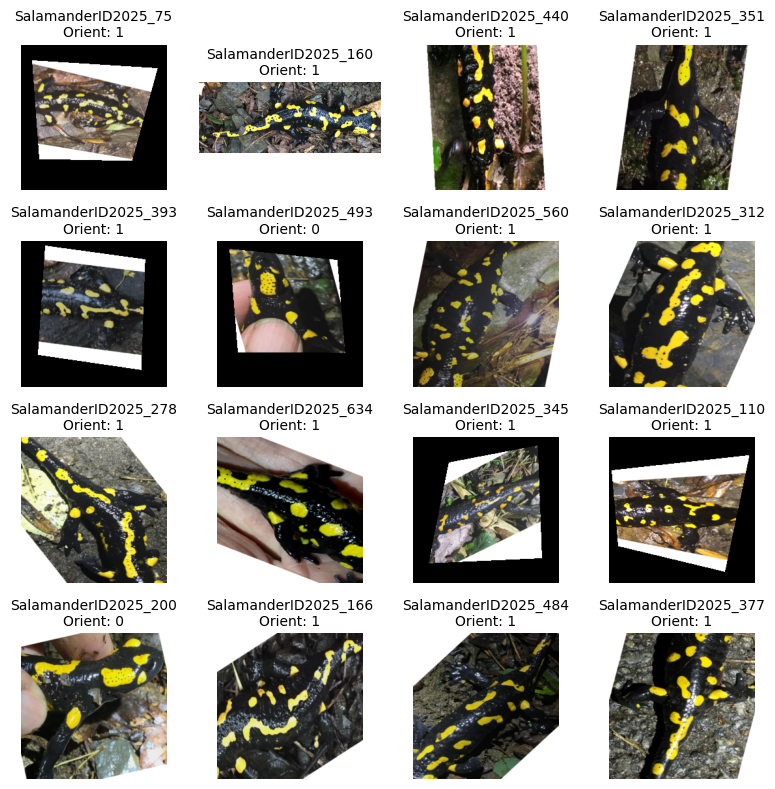

5874


In [7]:
import matplotlib.pyplot as plt

def show_augmented_samples(train_set, orientations, num_images=16):
    """
    显示增强后的一些图像
    Args:
        train_set: list of (image, label_str)
        orientations: list of int
    """
    indices = random.sample(range(len(train_set)), min(num_images, len(train_set)))
    images = [train_set[i][0] for i in indices]
    labels = [train_set[i][1] for i in indices]
    orients = [orientations[i] for i in indices]

    cols = 4
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(2 * cols, 2 * rows))
    for i, (img, label, orient) in enumerate(zip(images, labels, orients)):
        plt.subplot(rows, cols, i + 1)
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0)  # C×H×W → H×W×C
        plt.imshow(img)
        plt.title(f"{label}\nOrient: {orient}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_augmented_samples(train_set, orientations, num_images=16)
print(len(train_set))

## Dataset

In [8]:
from torch.utils.data import Dataset


class CustomImageDataset(Dataset):
    def __init__(self, data, label_to_index, orientations=None, species_to_index=None):
        """
        data: List of (image, label_str)
        """
        self.data = data
        self.label_to_index = label_to_index
        self.orientations = orientations
        self.species_to_index = species_to_index
        self.transform = T.Compose([
            T.Resize([224, 224]),
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label_str = self.data[idx]
        image = self.transform(image)
        if self.orientations is not None:
            species = label_str.split('_')[0]
            species_idx = self.species_to_index.get(species, -1)
            if label_str not in self.label_to_index:
                label_idx = -1
            else:
                label_idx = self.label_to_index[label_str]
            return image, label_idx, self.orientations[idx], species_idx
        else:
            return image


In [9]:
from torch.utils.data import Dataset
import torchvision.transforms as T
import random
from collections import defaultdict

class TripletImageDataset(Dataset):
    def __init__(self, data, label_to_index, orientations, species_to_index):
        self.label_to_index = label_to_index
        self.orientations = orientations
        self.species_to_index = species_to_index

        self.identity_to_images = defaultdict(list)
        for idx, (img, label) in enumerate(data):
            self.identity_to_images[label_to_index[label]].append((img, orientations[idx], label))

        self.identity_list = list(self.identity_to_images.keys())
        self.transform = T.Compose([
            T.Resize([224, 224]),
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        self.data = data

    def __len__(self):
        return len(self.identity_list)*2

    def __getitem__(self, index):
        anchor_class = random.choice(self.identity_list)
        positive_img, _, _ = random.choice(self.identity_to_images[anchor_class])
        anchor_img, anchor_orient, _ = random.choice(self.identity_to_images[anchor_class])

        # select a negative from a different class
        negative_class = random.choice([cls for cls in self.identity_list if cls != anchor_class])
        negative_img, _, neg_label = random.choice(self.identity_to_images[negative_class])

        anchor_img = self.transform(anchor_img)
        positive_img = self.transform(positive_img)
        negative_img = self.transform(negative_img)

        species_idx = self.species_to_index[neg_label.split('_')[0]]

        return anchor_img, positive_img, negative_img, anchor_orient, species_idx


## Model

In [10]:
import torch.nn as nn

class MultiTaskSwin(nn.Module):
    def __init__(self, pretrain_model, num_classes, num_orient, dropout_rate = 0.5, pretrained=True):
        super().__init__()

        # Load pretrained Swin model, without classification head
        self.backbone = timm.create_model(pretrain_model, pretrained=pretrained, num_classes=0)
        self.backbone_out_dim = self.backbone.num_features 

        self.output_layer = nn.Linear(self.backbone_out_dim, num_classes)

        # Orientation classification head
        self.orient_head = nn.Linear(self.backbone_out_dim, num_orient)

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x, labels=None):
        features = self.backbone(x)  # shape: [B, D]
        features = self.dropout(features)
        output = self.output_layer(features)         # [B, num_classes]
        orient_logits = self.orient_head(features) # [B, num_orient]
        return output, orient_logits

In [11]:
import timm
import torch.nn as nn
from AdaFace.head import AdaFace


class MultiTaskAdaSwin(nn.Module):
    def __init__(self, pretrain_model, num_classes, num_orient, embedding_dim=512, dropout_rate = 0.5, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(pretrain_model, pretrained=pretrained, num_classes=0)
        self.backbone_out_dim = self.backbone.num_features 

        self.dropout = nn.Dropout(dropout_rate)
        self.orient_head = nn.Linear(self.backbone_out_dim, num_orient)
        self.embedding_layer = nn.Linear(self.backbone_out_dim, embedding_dim)
        self.adaface_head = AdaFace(embedding_size=embedding_dim, classnum=num_classes, m = 0, h = 0, s = 64)


    def forward(self, x, labels=None):
        features = self.backbone(x)
        features = self.dropout(features)

        raw_embed = self.embedding_layer(features)
        norms = raw_embed.norm(p=2, dim=1, keepdim=True).detach()

        embedding = nn.functional.normalize(raw_embed, p=2, dim=1)

        orient_logits = self.orient_head(features)
        if labels is not None:
            logits = self.adaface_head(embedding, norms, labels)
            return logits, orient_logits
        else:
            return embedding, orient_logits


In [12]:
import timm
import torch.nn as nn
import torch.nn.functional as F

class MultiTaskSwinTriplet(nn.Module):
    def __init__(self, pretrain_model, num_orient, embedding_dim=512, dropout_rate=0.5, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(pretrain_model, pretrained=pretrained, num_classes=0)
        self.backbone_out_dim = self.backbone.num_features

        self.dropout = nn.Dropout(dropout_rate)
        self.embedding_layer = nn.Linear(self.backbone_out_dim, embedding_dim)
        self.orient_head = nn.Linear(self.backbone_out_dim, num_orient)

    def forward(self, x):
        features = self.backbone(x)
        features = self.dropout(features)

        raw_embed = self.embedding_layer(features)
        embedding = F.normalize(raw_embed, p=2, dim=1)
        orient_logits = self.orient_head(features)

        return embedding, orient_logits


## Train & Eval

In [13]:
from tqdm import tqdm

def train_cls(model, dataloader, optimizer, criterion, orient_criterion, device, orient_weight=0.1):
    model.train()
    total_losses, orient_losses, losses = [], [], []
    for images, labels, orient, _ in tqdm(dataloader):
        images, labels, orient = images.to(device), labels.to(device), orient.to(device)
        outputs, pred_orient = model(images, labels)
        loss = criterion(outputs, labels)
        loss_orient = orient_criterion(pred_orient, orient)
        total_loss = loss + orient_weight * loss_orient

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        total_losses.append(total_loss.item())
        orient_losses.append(loss_orient.item())
        losses.append(loss.item())
    return losses, orient_losses, total_losses

def predict_cls(loader, model, device, threshold = 0,unknown_class = -1):
    model.eval()
    y_true_all = []
    y_pred_all = []
    orient_all = []
    species_all = []
    pred_orient_all = []
    with torch.no_grad():
        for images, labels, orientations, species in loader:
            images = images.to(device)
            labels = labels.to(device)
            orientations = orientations.to(device)
            species = species.to(device)

            outputs, output_orient = model(images)
            probs = torch.softmax(outputs, dim=1)
            confidences, predicted_idx = torch.max(probs, dim=1)

            mask = confidences <= threshold
            predicted_idx[mask] = unknown_class

            y_true_all.append(labels)
            y_pred_all.append(predicted_idx)

            _, pred_orient = torch.max(output_orient, dim=1)
            pred_orient_all.append(pred_orient)
            orient_all.append(orientations)
            species_all.append(species)
    species_tensor = torch.cat(species_all)
    y_true_tensor = torch.cat(y_true_all)
    y_pred_tensor = torch.cat(y_pred_all)
    y_true_tensor_mapped = y_true_tensor.clone()
    y_true_tensor_mapped[torch.isin(y_true_tensor_mapped, torch.tensor(identity_test_only, device=y_true_tensor.device))] = unknown_class
    orient_tensor = torch.cat(orient_all)
    orient_pred_tensor = torch.cat(pred_orient_all)
    return y_true_tensor, y_pred_tensor, y_true_tensor_mapped, orient_tensor, orient_pred_tensor, species_tensor

In [14]:
from tqdm import tqdm


def train_triplet(model, dataloader, optimizer, triplet_criterion, orient_criterion, device, orient_weight=0.1):
    model.train()
    total_losses, orient_losses, losses = [], [], []

    for anchor_img, positive_img, negative_img, anchor_orient, _ in tqdm(dataloader):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        anchor_orient = anchor_orient.to(device)

        anchor_embed, anchor_orient_pred = model(anchor_img)
        positive_embed, _ = model(positive_img)
        negative_embed, _ = model(negative_img)

        loss = triplet_criterion(anchor_embed, positive_embed, negative_embed)
        loss_orient = orient_criterion(anchor_orient_pred, anchor_orient)
        total_loss = loss + orient_weight * loss_orient

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        total_losses.append(total_loss.item())
        orient_losses.append(loss_orient.item())
        losses.append(loss.item())

    return losses, orient_losses, total_losses

from collections import defaultdict

def build_gallery_center(model, gallery_loader, device):
    model.eval()
    identity_to_embeddings = defaultdict(list)

    with torch.no_grad():
        for images, labels, _, _ in gallery_loader:
            images = images.to(device)
            emb, _ = model(images)
            for e, l in zip(emb, labels):
                identity_to_embeddings[l.item()].append(e.cpu())

    gallery_centers = []
    gallery_labels = []

    for identity, embs in identity_to_embeddings.items():
        embs_tensor = torch.stack(embs)           # [N_i, D]
        center = embs_tensor.mean(dim=0)          # [D]
        gallery_centers.append(center)
        gallery_labels.append(identity)

    gallery_embeddings = torch.stack(gallery_centers).to(device)     # [G, D]
    gallery_labels = torch.tensor(gallery_labels, device=device)     # [G]

    return gallery_embeddings, gallery_labels

def predict_triplet(model, query_loader, gallery_embeddings, gallery_labels,
                             device, identity_test_only, threshold=0, unknown_class=-1):
    """
    - query_loader: 测试图像
    - gallery_embeddings: [G, D]，每个 identity 聚合后的 embedding
    - gallery_labels: [G]，对应 identity 的标签
    """
    model.eval()
    y_true_all = []
    y_pred_all = []
    orient_all = []
    species_all = []
    pred_orient_all = []

    with torch.no_grad():
        for images, labels, orientations, species in query_loader:
            images = images.to(device)
            labels = labels.to(device)
            orientations = orientations.to(device)
            species = species.to(device)

            emb, orient_logits = model(images)  # [B, D]
            sim = F.cosine_similarity(emb.unsqueeze(1), gallery_embeddings.unsqueeze(0), dim=2)  # [B, G]
            confidences, topk_idx = torch.max(sim, dim=1)
            predicted = gallery_labels[topk_idx]
            predicted[confidences <= threshold] = unknown_class

            y_true_all.append(labels)
            y_pred_all.append(predicted)
            orient_all.append(orientations)
            species_all.append(species)
            _, pred_orient = torch.max(orient_logits, dim=1)
            pred_orient_all.append(pred_orient)

    # 拼接输出
    species_tensor = torch.cat(species_all)
    y_true_tensor = torch.cat(y_true_all)
    y_pred_tensor = torch.cat(y_pred_all)
    y_true_tensor_mapped = y_true_tensor.clone()
    y_true_tensor_mapped[torch.isin(y_true_tensor_mapped, torch.tensor(identity_test_only, device=device))] = unknown_class
    orient_tensor = torch.cat(orient_all)
    orient_pred_tensor = torch.cat(pred_orient_all)

    return y_true_tensor, y_pred_tensor, y_true_tensor_mapped, orient_tensor, orient_pred_tensor, species_tensor


In [15]:
def eval(y_true_tensor, y_pred_tensor, y_true_tensor_mapped, orient_tensor, orient_pred_tensor, species_tensor, unknown_class=-1):
    metrics = {}
    for mask, species in index_to_species.items():
        y_true = y_true_tensor[species_tensor == mask]
        y_pred = y_pred_tensor[species_tensor == mask]
        y_true_mapped = y_true_tensor_mapped[species_tensor == mask]
        acc = (y_true_mapped == y_pred).float().mean().item()
        baks = BAKS(y_true, y_pred, identity_test_only)
        baus = BAUS(y_true, y_pred, identity_test_only, new_class=unknown_class)
        score = np.sqrt(baks * baus)
        orient_gt = orient_tensor[species_tensor == mask]
        orient_pred = orient_pred_tensor[species_tensor == mask]
        orient_acc = (orient_gt == orient_pred).float().mean().item()
        metrics[species] = {
            'baks': baks,
            'baus': baus,
            'acc': acc,
            'score': score,
            'orient_acc': orient_acc
        }
    return metrics

## Pipeline

In [21]:
train_dataset = CustomImageDataset(train_set, label_to_index, orientations, species_to_index)
# train_dataset = TripletImageDataset(train_set, label_to_index, orientations, species_to_index)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# gallery_dataset = CustomImageDataset(train_set, label_to_index, orientations, species_to_index)
# gallery_loader = torch.utils.data.DataLoader(gallery_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

test_dataset = CustomImageDataset(test_set, label_to_index, orientations, species_to_index)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [22]:
import timm

num_classes = len(identity_train)
num_orient = len(all_orientation)

# model = timm.create_model(pretrain_model, pretrained=True, num_classes=num_classes)
model = MultiTaskSwin(pretrain_model, num_classes, num_orient, dropout_rate=dropout_rate)
# model = MultiTaskAdaSwin(pretrain_model, num_classes, num_orient, dropout_rate=dropout_rate)
# model = MultiTaskSwinTriplet(pretrain_model, num_orient, dropout_rate=dropout_rate)

model = model.to(device)

In [23]:
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = nn.CrossEntropyLoss()
# triplet_criterion = nn.TripletMarginLoss(margin=0.3, p=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=30)

In [24]:
if freeze_layers:
    for name, param in model.named_parameters():
        if name.startswith("backbone.patch_embed") or name.startswith("backbone.layers.0") or name.startswith("backbone.layers.1"):
            param.requires_grad = False
        # if param.requires_grad:
        #     print(name, param.shape)

100%|██████████| 46/46 [00:47<00:00,  1.02s/it]


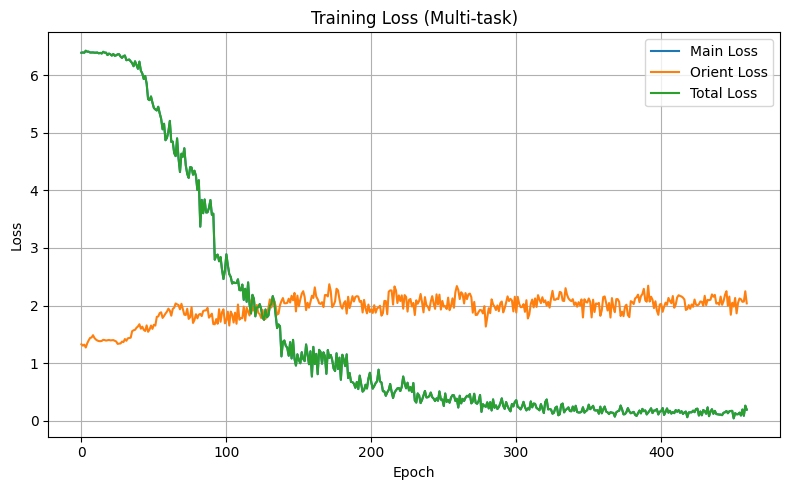

In [25]:
from tqdm import tqdm

losses = []
orient_losses = []
total_losses = []
for epoch in range(num_epochs):
    loss, orient_loss, total_loss = train_cls(model, train_loader, optimizer, criterion, criterion, device, orient_weight=orient_weight)
    # loss, orient_loss, total_loss = train_triplet(model, train_loader, optimizer, triplet_criterion, criterion, device, orient_weight=orient_weight)
    losses.extend(loss)
    orient_losses.extend(orient_loss)
    total_losses.extend(total_loss)

    scheduler.step()
    lr_now = scheduler.get_last_lr()[0]
    logging.info(f"[Epoch {epoch+1}] Loss: {sum(loss)/len(loss):.4f}, Orient Loss: {sum(orient_loss)/len(orient_loss):.4f}")

    # gallery_embeddings, gallery_labels = build_gallery_center(model, gallery_loader, device)
    y_true_tensor, y_pred_tensor, y_true_tensor_mapped, orient_tensor, orient_pred_tensor, species_tensor = predict_cls(train_loader, model, device)
    # y_true_tensor, y_pred_tensor, y_true_tensor_mapped, orient_tensor, orient_pred_tensor, species_tensor = predict_triplet(model, gallery_loader, gallery_embeddings, gallery_labels,
                        #  device, identity_test_only)
    train_metrics = eval(y_true_tensor, y_pred_tensor, y_true_tensor_mapped, orient_tensor, orient_pred_tensor, species_tensor)
    # y_true_tensor, y_pred_tensor, y_true_tensor_mapped, orient_tensor, orient_pred_tensor, species_tensor = predict_cls(test_loader, model, device)
    # y_true_tensor, y_pred_tensor, y_true_tensor_mapped, orient_tensor, orient_pred_tensor, species_tensor = predict_triplet(model, test_loader, gallery_embeddings, gallery_labels,
    #                      device, identity_test_only)
    # test_metrics = eval(y_true_tensor, y_pred_tensor, y_true_tensor_mapped, orient_tensor, orient_pred_tensor, species_tensor)
    final_scores = []
    for species, metrics in train_metrics.items():
        baks = metrics['baks']
        baus = metrics['baus']
        acc = metrics['acc']
        score = metrics['score']
        orient_acc = metrics['orient_acc']
        final_scores.append(score)
        logging.info(f"Train - Species: {species}, BAKS: {baks:.4f}, BAUS: {baus:.4f}, Accuracy: {acc:.4f}, scores: {np.sqrt(baks*baus):.4f}, Orient Acc: {orient_acc:.4f}")
    logging.info(f"Train - Final Score: {np.mean(final_scores):.4f}")
    # for species, metrics in test_metrics.items():
    #     baks = metrics['baks']
    #     baus = metrics['baus']
    #     acc = metrics['acc']
    #     score = metrics['score']
    #     orient_acc = metrics['orient_acc']
    #     final_scores.append(score)
    #     logging.info(f"Test - Species: {species}, BAKS: {baks:.4f}, BAUS: {baus:.4f}, Accuracy: {acc:.4f}, scores: {np.sqrt(baks*baus):.4f}, Orient Acc: {orient_acc:.4f}")
    # logging.info(f"Test - Final Score: {np.mean(final_scores):.4f}")

plt.figure(figsize=(8, 5))
plt.plot(losses, label='Main Loss')
plt.plot(orient_losses, label='Orient Loss')
plt.plot(total_losses, label='Total Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (Multi-task)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the model
torch.save(model.state_dict(), output_path)

# Inference

In [27]:
pretrain_model = 'swin_tiny_patch4_window7_224'
output_model = 'final_inference_20250513_003711'
output_path = f'./model/{output_model}.pth'

model = MultiTaskSwin(pretrain_model, num_classes, num_orient, dropout_rate = 0)
model.load_state_dict(torch.load(output_path))
model.to(device)


MultiTaskSwin(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=

In [28]:
model.eval()

with torch.no_grad():
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
        y_true_tensor, y_pred_tensor, y_true_tensor_mapped, orient_tensor, orient_pred_tensor, species_tensor = predict_cls(test_loader, model, device, threshold=threshold)
        metrics = eval(y_true_tensor, y_pred_tensor, y_true_tensor_mapped, orient_tensor, orient_pred_tensor, species_tensor)
        final_scores = []
        for species, metrics in metrics.items():
            baks = metrics['baks']
            baus = metrics['baus']
            acc = metrics['acc']
            score = metrics['score']
            orient_acc = metrics['orient_acc']
            final_scores.append(score)
            print(f"Eval - Species: {species}, BAKS: {baks:.4f}, BAUS: {baus:.4f}, Accuracy: {acc:.4f}, scores: {np.sqrt(baks*baus):.4f}, Orient Acc: {orient_acc:.4f}")
        print(f"Eval - Final Score: {np.mean(final_scores):.4f}")

RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [ ]:
new_individual = 'new_individual'
threshold = 0.4
dataset_query = dataset.get_subset(dataset.metadata['split'] == 'query')
inference_dataset = CustomImageDataset(dataset_query, label_to_index)
inference_loader = torch.utils.data.DataLoader(inference_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=False)
model.eval()
with torch.no_grad():
    outputs = []
    for images in inference_loader:
        images = images.to(device)
        output, _ = model(images)
        outputs.append(output)
    outputs = torch.cat(outputs, dim=0)
    pred_scores = torch.softmax(outputs, dim=1)
    predicted_idx = torch.max(outputs, dim=1)[1]
    pred_classes = predicted_idx.cpu().tolist()
    predictions = [index_to_label[idx] for idx in pred_classes]
    confidences = pred_scores.max(dim=1)[0]
    final_predictions = []
    for pred_label, conf in zip(predictions, confidences):
        if conf < threshold:
            final_predictions.append(new_individual)
        else:
            final_predictions.append(pred_label)

create_sample_submission(dataset_query, final_predictions, file_name=f'./output/{output_model}.csv')